# Modely pro predikci šíření Coronaviru a nemoci COVID-19 v různých zemích

Tomáš Kulhánek<sup>1,2</sup>, Jiří Kofránek<sup>1,2</sup>

<sup>1</sup>Oddělení biokybernetiky a počítačové podpory výuky, ÚPF, 1.LFUK <sup>2</sup>Creative Connections,s.r.o. 

Tento notebook není oficiální zdroj informací, používá data z věřejných zdrojů. Pokud najdete nějakou chybu, tak ji reportujte jako github issue nebo PR. 

Repository is still work in progress and will involve work over the next days/weeks obsahuje porovnání tzv. logistického modelu a exponenciálního modelu, které se používají pro predikci šíření jakékoliv nákazy. 

Příklady data a predikce jsou provedeny pro šíření nákazy Coronavirem a infekce nemoci COVID-19 ve světě a v Česku. Data jsou získávána z věřejných zdrojů - viz Reference dole. Pro výpočty a se používá jazyk Python a knihovny pro podporu datové vědy.

Tento notebook (zápisník) je interaktivní, s textovými buňkami a buňkami s kódem. Je možné se v něm pohybovat šipkami nahoru a dolů. Pro vykonání kódu v buňkách stiskněte `Shift-Enter`. Obsah buněk je editovatelný, v tom případě po změně kódu můžete pustit skript s jinými parametry pomocí zmíněného `Shift-Enter`.

Nejprve importujeme knihovny

In [1]:
# First we import related python libs used further
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
%matplotlib inline

Nyní definujeme rutiny pro stažení dat, cache dat a úpravu dat dle různých formátů do tabulky pandas v prvním sloupci den, v druhém sloupci počet nakažených.

In [2]:
#cache data
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dfi = pd.read_csv(url)
#data from Italian national agency, seems to be updated in daily basis
def getdatafromItaly():
    global dfi
    df = dfi
    df = df.loc[:,['data','totale_casi']]
    FMT = '%Y-%m-%d %H:%M:%S'
    date = df['data']
    df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )
    return df

In [3]:
#cache data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
dfw = pd.read_csv(url)
def getdatafromWHO(country,addlastdaynum=0):
    global dfw
    df3 = dfw
    #select country,region
    dfcz = df3.loc[df3['Country/Region']==country,:]
    #select only data relevant of coronavirus COVID-19, strip country name, location,... 
    dfcz2 = dfcz.iloc[:,4:]
    #strip columns where infected is 0
    dfcz21 = dfcz2.loc[:, (dfcz2 != 0).any(axis=0)]
    dfcz22 = dfcz21.rename(index={dfcz21.first_valid_index():"infected"},errors="raise")
    #transpose
    dfcz3 = dfcz22.transpose()
    #calculate number of days from 1.1.2020 based on date in first column
    d = (datetime.strptime(dfcz21.columns[0], "%m/%d/%y")-datetime(2020,1,1)).days
    #insert just day numbers 
    dfcz3.insert(0,'days',range(d,int(d+len(dfcz3.index))))
    #optionally append one number with most updated data - 13.3. number 113
    if (addlastdaynum>0):
        dfcz33 = dfcz3.append({"days":d+len(dfcz3.index),"infected":addlastdaynum},ignore_index=True)
        return dfcz33
    return dfcz3
    #print(dfcz33,df2)
    

In [4]:
def getdatafromCzechia():
    # TODO CSV resource not found yet, manually updated every day, https://onemocneni-aktualne.mzcr.cz/covid-19
    crdata=[['days','infected'],[61,3],[62,3],[63,5],[64,5],[65,8],[66,19],[67,26],[68,32],[69,38],[70,63],
            [71,94],[72,116],[73,141],[74,189],[75,298],[76,383],[77,436],[78,560]]
    df2 = pd.DataFrame(crdata[1:],columns=crdata[0])
    return df2

## Logistický model
Logistický model se používá např. pro zkoumání výskytu onemocnění a šíření v populaci. Více viz https://en.wikipedia.org/wiki/Logistic_regression

$$ f(x,a,b,c)= \frac{c}{1+e^\frac{-(x-b)}{a} } $$

* $x$ čas
* $a$ rychlost infekce
* $b$ kritický bod, den kdy se nakazilo nejvíce lidí
* $c$ celkový počet nakažených lidí

In [5]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



# Exponenciální model
Exponenciální model, lépe vystihuje šíření nákazy na počátku šíření. Obvykle je omezeno velikostí populace, příp. 

$$ f(x,a,b,c)= a.e^{b(x-c)} $$

In [6]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

 # Fitování dat na model
 Modely mají parametry, které lze odhadnout na základě proložení reálnými daty. Použijeme metody `curve_fit` z knihovny `scipy`. 

In [7]:
def getxy(dfcz33):
    x = list(dfcz33.iloc[:,0])
    y = list(dfcz33.iloc[:,1])
    return (x,y)

def fitlogisticmodel(x,y):
    #fit data to logistic model
    fit=[[4,75,100000]]
#    try:
        #fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],method='lm')#,bounds=([0.5,30,15][10,120,10e+7]))
        #fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],method='lm',maxfev=5000)#,bounds=([0.5,30,15][10,120,10e+7]))
    fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],maxfev=5000,bounds=([0.5,30,300],[10,120,7e+6]))
#    except:
#        print('fit not found, attemp 0');
#        for i in range(1,5):
#            try:
#                fit = curve_fit(logistic_model,x,y,p0=[i,70,i*1000**(i/3)],bounds=([0.5,60,15][10,120,1e+7]),maxfev=5000)
#                break;
#            except:
#                print('fit not found, attemp ',i);
    #a,b,c parameters of model, c total infected, b reversal day number of daily infected starts decrease
    (a,b,c)=(fit[0][0],fit[0][1],fit[0][2])
    #lastday when somebody is infected
    lastday = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    #errors - uncertainty
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    print('Parameters of logistic model fit a:',a,' b:',b,' c:',c,' errors of c:',errors[2])
    return (fit,lastday,errors)

def fitlogisticmodel_b(x,y,fixb):
    #fit data to logistic model with already estimated parameter B 
    fit = curve_fit(logistic_model,x,y,p0=[2,fixb,20000],bounds=[[1,fixb,150],[10,fixb+1,10e+6]])
    
    #a,b,c parameters of model, c total infected, b reversal day number of daily infected starts decrease
    (a,b,c)=(fit[0][0],fit[0][1],fit[0][2])
    #lastday when somebody is infected
    lastday = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    #errors - uncertainty
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    print('Parameters of logistic model fit a:',a,' b:',b,' c:',c,' errors of c:',errors[2])
    return (fit,lastday,errors)

In [8]:
def fitexponentialmodel(x,y):
    #fit data to exponential model
    exp_fit = curve_fit(exponential_model,x,y,p0=[0.02,0.1,2.8])
    return exp_fit


# Vizualizace výsledků predikce modelů a reálných dat

Nyní definujeme rutiny pro vizualizaci výsledků predikce jednotlivých modelů s reálnými daty.

In [9]:
def plotchart(x,y,lastday,fit,exp_fit,errors):
    pred_x = list(range(max(x),lastday))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
    # line with predicted total infected
    plt.axhline(y=fit[0][2], color='b', linestyle='dotted')
    plt.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    # uncertainty interval +- errors
    plt.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,fit[0][2]*1.1))
    plt.show()
    
def plotcharts(x,y,lastday,fit,exp_fit,errors,lastday2,fit2,exp_fit2,errors2):
    pred_x = list(range(max(x),lastday))
    pred_x2 = list(range(max(x),lastday2))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=12)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Optimistic L. model" )
    plt.plot(x+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Realistic L. model b=85" )
    # Predicted exponential curve
    plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    plt.axhline(y=fit[0][2], color='g', linestyle='dotted')
    plt.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    plt.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    plt.text(lastday2-2,fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    plt.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1))    
    plt.show()

def plotcharts_norm_vs_log(x,y,lastday,fit,exp_fit,errors,lastday2,fit2,exp_fit2,errors2):
    pred_x = list(range(max(x),lastday))
    pred_x2 = list(range(max(x),lastday2))
    plt.rcParams['figure.figsize'] = [14, 7]
    plt.rc('font', size=10)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Real data
    ax1.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    ax1.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Optimistic logistic model b="+str(int(fit[0][1])))
    ax1.plot(x+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Realistic logistic model b="+str(int(fit2[0][1]))) 
    # Predicted exponential curve
    ax1.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    ax1.axhline(y=fit[0][2], color='g', linestyle='dotted')
    ax1.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    ax1.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    ax1.text(lastday2-2,fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    ax1.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    ax1.legend()
    ax1.set(xlabel="Days since 1 January 2020",ylabel="Total number of infected people",
            ylim=(min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1))    

    # Real data
    ax2.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    ax2.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Optimistic logistic model b="+str(int(fit[0][1])))
    ax2.plot(x+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Realistic logistic model b="+str(int(fit2[0][1])))
    # Predicted exponential curve
    ax2.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    ax2.axhline(y=fit[0][2], color='g', linestyle='dotted')
    ax2.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    ax2.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    ax2.text(lastday2-2,fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    ax2.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    ax2.legend()
    ax2.set(xlabel="Days since 1 January 2020",ylabel="Total number of infected people, log scale",
            ylim=(min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1),    
            yscale="log")
    
    plt.show()
    

# Analýza dat

Nyní můžeme už definovat sekvenci volání funkcí pro analýzu dat.

In [10]:

def analyze_data(df,estb=0):
    (x,y) = getxy(df)
    #try to fit all parameters a,b,c    
    (fit,lastday,errors) = fitlogisticmodel(x,y)
    #try to fit parameters a,c, 
    #estimate b (critical point) as e.g. 7-14 days after 
    #quarantine and other actions were introduced in population
    fit_exp = fitexponentialmodel(x,y)
    date_lastday=datetime(2020,1,1) + timedelta(days=lastday)    
    if estb>0:
        (fit2,lastday2,errors2) = fitlogisticmodel_b(x,y,estb)
        plotcharts_norm_vs_log(x,y,lastday,fit,fit_exp,errors,lastday2,fit2,fit_exp,errors2)
    else:
        plotchart(x,y,lastday,fit,fit_exp,errors)
    return (date_lastday,fit,errors)
    
def analyze_for_country(country,addlastnum=0,estb=0):
    # get data from WHO
    df = getdatafromWHO(country,addlastnum)
    (date_lastday,fit,errors) = analyze_data(df,estb)
    #print('Model of COVID-19 infection in',country,'based on real data predicts last infected person at ',date_lastday.strftime('%d.%m.%Y'),' with total infected people ',int(fit[0][2]),'(+-', int(errors[2]),'). ')

def analyze_czechia(estb=0):    
    df = getdatafromCzechia()
    (date_lastday,fit,errors) = analyze_data(df,estb)
    #print('Model of COVID-19 infection in Czechia based on real data predicts last infected person at ',date_lastday.strftime('%d.%m.%Y'),' with total infected people ',int(fit[0][2]),'(+-', int(errors[2]),'). ')


# Model prediction for Czechia

Data are available from [3] and [2]. The data and model prediction differs. Thus comparing model prediction for both data.

Parameters of logistic model fit a: 2.801391429114074  b: 76.6638871051063  c: 878.7787343017391  errors of c: 112.16522574221791
Parameters of logistic model fit a: 3.7464343309508568  b: 85.00000000000001  c: 4581.979982350491  errors of c: 7980.395826721318


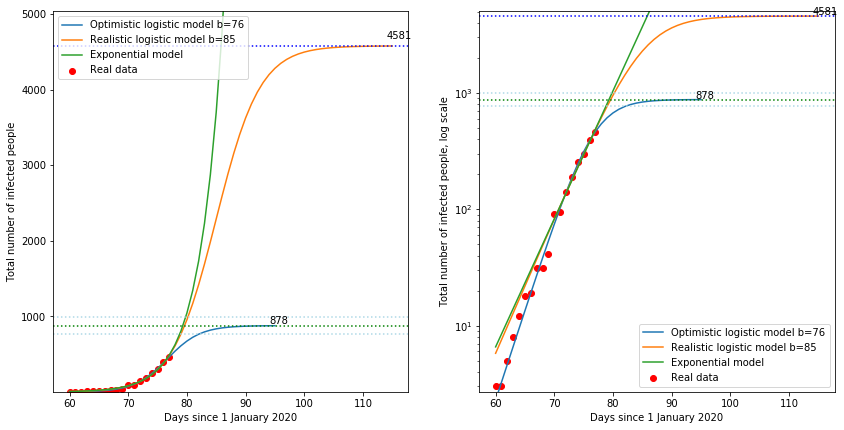

In [11]:
analyze_for_country('Czechia',estb=85) #update 14:18, 13.3.2020 total number of cases reported 120 - being updated manually


Parameters of logistic model fit a: 2.7899101016182426  b: 78.1064303219497  c: 1133.3613631058054  errors of c: 210.97513719237818
Parameters of logistic model fit a: 3.5768122746054587  b: 85.0000000000053  c: 4637.133490429653  errors of c: 6928.642987527475


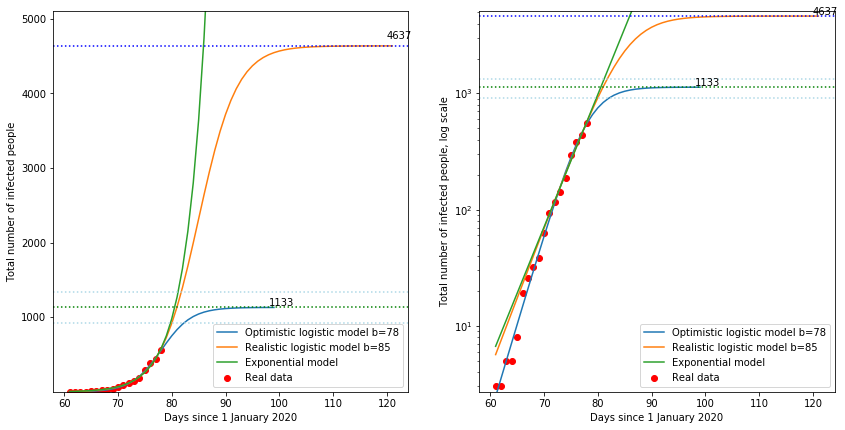

In [12]:
analyze_czechia(estb=85)

## Shrnutí pro Česko
Modely jsou citlivé na reálná data, nicméně z WHO i z českých zdrojů [2],[3] se predikce shodnou v řádu (1518 vs 966). Každý den nicméně počet potvrzených nakažených roste. Z reálných dat plyne, že se ještě nedosáhlo kritického bodu b, proto odhady modelů se každý den zvyšují. Přidali jsme proto odhad parametru b na den 85 - tj. 25.3.2020 (viz Realistic logistic model), kdy by mohl být největší nárůst zaznamenaných nakažených - odhadnuto jako 12 dní (7-14 dnů je inkubační doba nemoci) po vyhlášení opatřeních vládou z 13.3.2020.

Uvidíme jak realistický odhad modelu bude odpovídat zpřesňujícím se datum v budoucnu (psáno 16.3.2020)

# Model a predikce pro Jižní Koreu

Parameters of logistic model fit a: 2.981546984586496  b: 60.68321533791318  c: 8213.51118413528  errors of c: 32.33193214926192


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


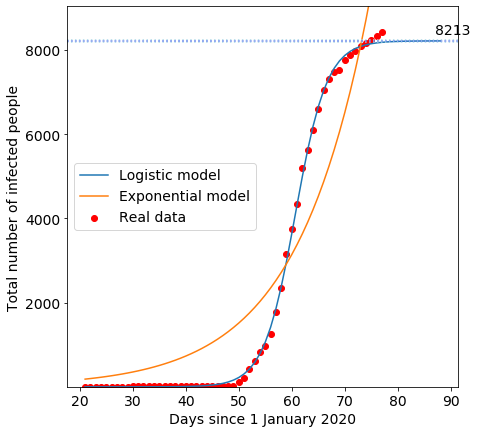

In [13]:
analyze_for_country('Korea, South')

## Shrnutí pro Jižní Koreu
Z reálných dat plyne, že v Koreji se již dosáhlo bodu b a proto predikce modelu se již každým dnem výrazně už nemění.
13.3. predikce 7982 (+- 38 ). 16.3. predikce 8097 (+-32). A chování modelů více odpovídá Logistické křivce než exponenciálnímu modelu.

Lze i s opatrností interpretovat, že v Jižní Koreji již mají šíření nemoci COVID-19 více pod kontrolou.

# Model a predikce pro Itálii

Data jsou dostupné z WHO a z italského zdroje[1] [3]. 

Parameters of logistic model fit a: 4.530080811997912  b: 77.29933111900841  c: 74036.41315060783  errors of c: 6249.774907910345
Parameters of logistic model fit a: 5.114601952389606  b: 81.00000000000001  c: 116528.6052546041  errors of c: 21839.428628725964


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


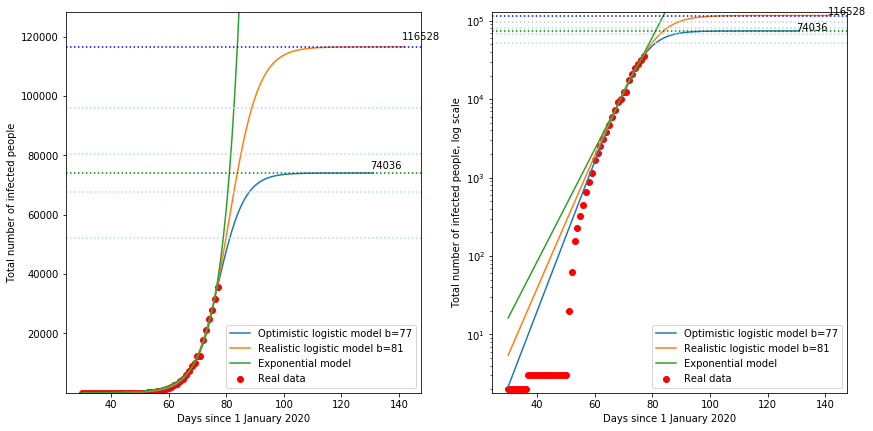

In [14]:
analyze_for_country('Italy',estb=81)

Parameters of logistic model fit a: 4.446493801237864  b: 76.51935897533741  c: 67488.04467997812  errors of c: 2713.4692323789095
Parameters of logistic model fit a: 5.198328570403066  b: 81.00000000000003  c: 115492.16094204895  errors of c: 23017.96551352645


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


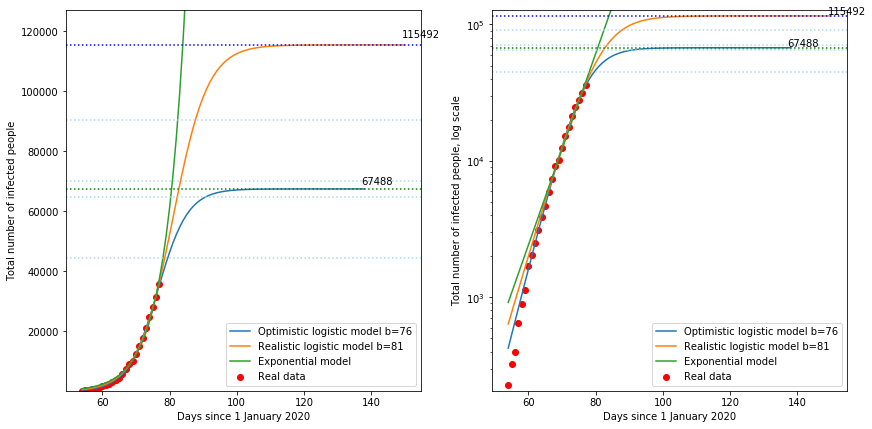

(datetime.datetime(2020, 5, 19, 0, 0),
 (array([4.44649380e+00, 7.65193590e+01, 6.74880447e+04]),
  array([[6.01759292e-03, 2.47542336e-02, 1.93952411e+02],
         [2.47542336e-02, 1.14462665e-01, 9.13997362e+02],
         [1.93952411e+02, 9.13997362e+02, 7.36291528e+06]])),
 [0.07757314559280828, 0.3383233146144738, 2713.4692323789095])

In [15]:
df3=getdatafromItaly()
analyze_data(df3,estb=81)

## Shrnutí pro Itálii 
Modely jsou citlivé na vstupní data,[1] a [3]. 
* 13.3. predikce 42393 (+-7887) vs 19293 (+-1111). 
* 16.3. predikce 73519 (+-9427) vs 134252 (+-65720). 

Přidáváme odhad 12 dnů od 9.3.2020 po vyhlášení rozsáhlých karanténních opatřeních v Itálii, tj. b=81 (21. březen +60 dnů leden a únor).
* 16.3. Realistický model predikuje 128639 (+-41596).

# Další země

In [16]:
# do analysis for your country, check correct country/region name in data source [3]
print(dfw[['Country/Region']])

     Country/Region
0          Thailand
1             Japan
2         Singapore
3             Nepal
4          Malaysia
..              ...
457     Netherlands
458          Zambia
459        Djibouti
460     Gambia, The
461  United Kingdom

[462 rows x 1 columns]


Parameters of logistic model fit a: 2.4222635333299896  b: 74.91798458046867  c: 19597.99630486374  errors of c: 1093.775230267269
Parameters of logistic model fit a: 4.005698107289958  b: 90.00000000000001  c: 394852.20480899856  errors of c: 1910868.2351099623


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


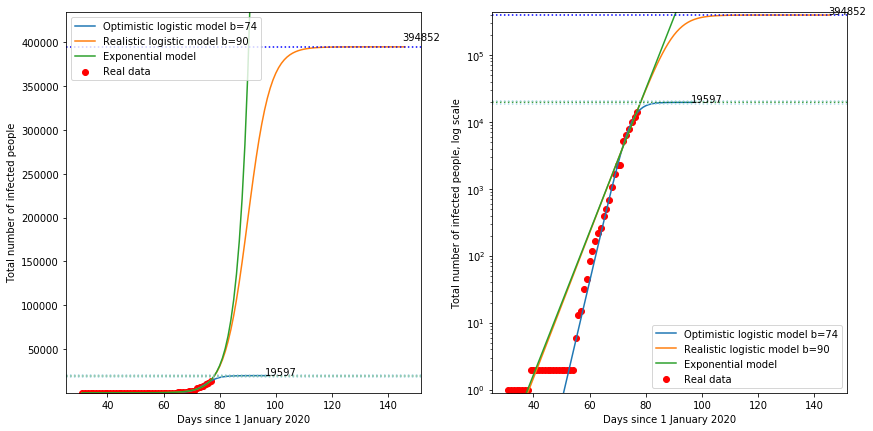

In [17]:
# replace country name 
analyze_for_country('Spain',estb=90)

# References
* [1] Gianluca Malato, Covid-19 infection in Italy. Mathematical models and predictions. Data from Italy https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* [2] Data from Czechia https://onemocneni-aktualne.mzcr.cz/covid-19
* [3] World data updated by Johns Hopkins University Center for Systems Science and Engineering https://github.com/CSSEGISandData/COVID-19